# HW3_1 - Expectation Maximization and Principal Component Analysis - Solutions

Prof. Dimitrios Milioris

Learning contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

#### We use `iris` dataset from `sklearn`

(<matplotlib.collections.PathCollection at 0x7fcba82ca940>,
 <matplotlib.legend.Legend at 0x7fcba82cac70>)

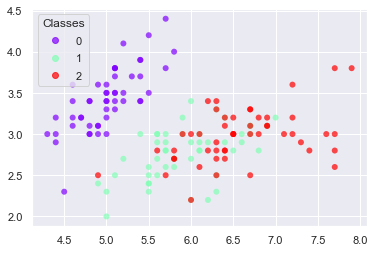

In [21]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

`gaussian_mixture` takes data point (vector) `x`, set of multivariate `means` and respective `covariances`, and `pis` (coeficients) and should return Probability Density Function value at point x.

In [22]:
def gaussian_mixture(x, means, covariances, pis):
    result = 0
    
    for i, (mean, covariance, pi) in enumerate(zip(means, covariances, pis)):
        result += pi * multivariate_normal(mean=mean, cov=covariance, allow_singular=True).pdf(x)
    
    return result

`expectation_maximization_gaussian` takes initial means `mus_0`, covariances `covariances_0` and coeficients `pis_0`, data set `data_x` and callback `on_step`.

`on_step` is a function that takes current set of `mus`, corresponding `covariances` and `pis`, value of `log_likelihood` and list of class `predictions` for each point (\[0...k\]) and should be called each step 

In [23]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x, on_step):
    
    eps = 1e-8
    
    K = len(mus_0)
    N = len(data_x)
    
    current_mus = mus_0
    current_covariances = covariances_0
    current_pis = pis_0
    
    old_log_likelihood = None
    
    for i in range(50):
        
        current_mus = np.copy(current_mus)
        current_covariances = np.copy(current_covariances)
        current_pis = np.copy(current_pis)
        
        
        likelihood = []
        for k in range(K):
            likelihood.append(multivariate_normal.pdf(x=data_x, mean=current_mus[k], cov=current_covariances[k], allow_singular=True))
        likelihood = np.array(likelihood)
        predictions = np.argmax(likelihood, axis=0)
        
        gamma = []
        
        all_likelihoods = []
        
        for k in range(K):
            
            all_likelihoods.append(likelihood[k] * current_pis[k])
            
            gamma.append((likelihood[k] * current_pis[k]) / (np.sum([likelihood[i] * current_pis[i] for i in range(K)], axis=0) + eps))

            current_mus[k] = np.sum(gamma[k].reshape(len(data_x),1) * data_x, axis=0) / (np.sum(gamma[k] + eps))
            current_covariances[k] = np.dot(
                (gamma[k].reshape(len(data_x),1) * (data_x - current_mus[k])).T, (data_x - current_mus[k])
            ) / (np.sum(gamma[k]) + eps)

            current_pis[k] = np.mean(gamma[k])
        
        log_likelihood = np.sum(np.log(np.sum(all_likelihoods, axis=0)))
        
        on_step(current_mus, current_covariances, current_pis, log_likelihood, predictions)
        
        if (old_log_likelihood is not None) and (abs(log_likelihood - old_log_likelihood) < 0.05):
            return
        old_log_likelihood = log_likelihood

### 1.1) Display results

In [24]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

In [25]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x,
    lambda mus, covs, pis, log_likelihood, predictions: all_steps_em.append((mus, covs, pis, log_likelihood, predictions))
)

RuntimeError: Requested MovieWriter (ffmpeg) not available

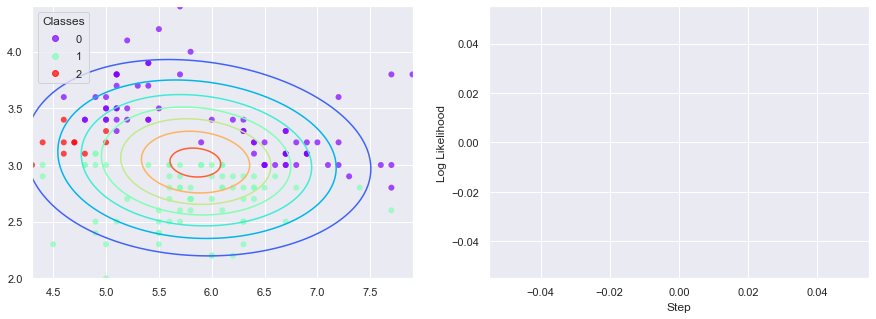

In [26]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

### 1.2) Nearest Centroid-based classification

`nearest_centroid_based_class` takes data point `x`, set of means `mus` and `covariances` and returns class of this point

In [27]:
def nearest_centroid_based_class(x, mus, covariances):

    distances = list(map(
        lambda mu_cov: (x - mu_cov[0]).T @ np.linalg.inv(mu_cov[1]) @ (x - mu_cov[0]),
        zip(mus, covariances)
    ))
    return np.argmin(distances)

RuntimeError: Requested MovieWriter (ffmpeg) not available

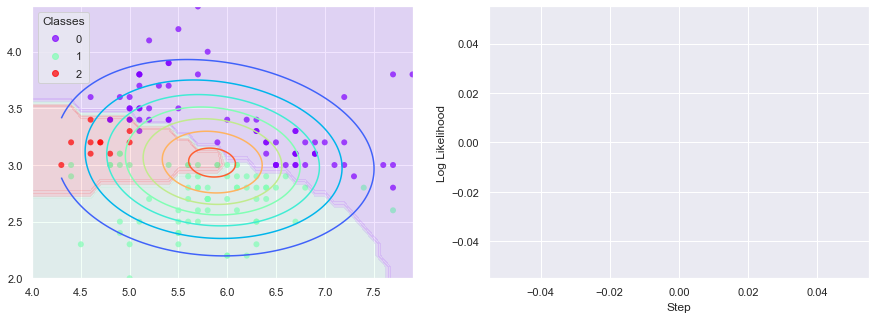

In [28]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

## 2) Principal Component Analysis

### 2.1) Generate data

/var/folders/13/g08vx41966s2q32c7stvcpqh0000gn/T/ipykernel_9716/307051164.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


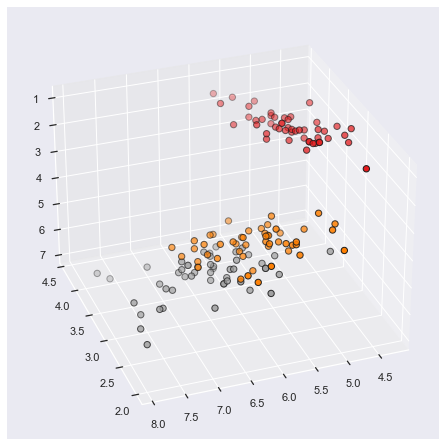

In [29]:
iris4_x = np.array(iris.data[:, :4])

def plot_classes_3d(data, classes):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.show()
plot_classes_3d(iris4_x[:, :3], iris_t)

### 2.2) Apply PCA

`pca_projection` takes data points `data`, number of `components` as arguments and returns PCA projection of the data

In [30]:
def pca_projection(data, components):
    
    mean = np.mean(data, axis=0)
    
    cov = np.cov(data, rowvar=False)
    values, vectors = np.linalg.eigh(cov)
    
    total = [*zip(values, vectors)]
    total.sort(reverse=True)

    U = np.array([vec for (val, vec) in total[:components]])
    
    return data @ U.T

### 2.3) Display projection

(<matplotlib.collections.PathCollection at 0x7fcb9980e550>,
 <matplotlib.legend.Legend at 0x7fcb9980efa0>)

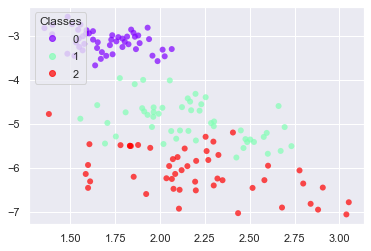

In [31]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)

/var/folders/13/g08vx41966s2q32c7stvcpqh0000gn/T/ipykernel_9716/307051164.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


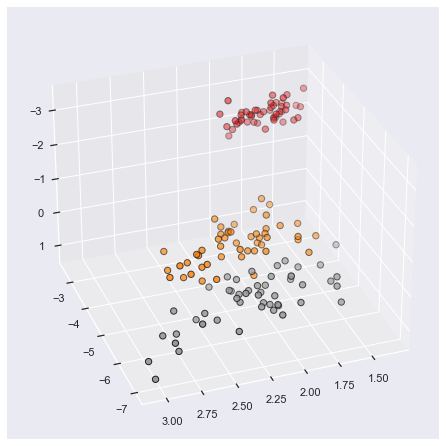

In [32]:
projected_data = pca_projection(iris4_x, 3)
plot_classes_3d(projected_data, iris_t)